In [42]:
import numpy as np
from scipy import *
from scipy.optimize import fsolve
from numpy import random
import seaborn as sns
import matplotlib.pyplot as plt
from gurobipy import *
from sklearn.model_selection import train_test_split
#import cvxpy as cp
from scipy.linalg import fractional_matrix_power
from numpy.linalg import inv
import pandas as pd
from scipy.optimize import minimize
from scipy.optimize import NonlinearConstraint
from mpl_toolkits.mplot3d import Axes3D
import time
import pickle
from scipy.stats import gaussian_kde
from matplotlib import gridspec

# from sklearn.linear_model import Ridge
# from sklearn.linear_model import LassoCV
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import MultiTaskLassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import train_test_split, KFold
import warnings

from scipy.stats import bernoulli

import gc

from rsome import ro
from rsome import grb_solver as grb

seed = 3

In [3]:
import os
import pathlib
data_generation_process = "DDR_Data_Generation"
current_directory = os.getcwd()
print("current_directory:", current_directory)
project_directory = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(current_directory))))
print("project_directory:", project_directory)
Result_Path = project_directory + "/Data_JOC_R1/DDR/"
print("Result_Path:", Result_Path)
Result_Path_Section = Result_Path + "All_Results/"
print("Result_Path_Section:", Result_Path_Section)
pathlib.Path(Result_Path_Section).mkdir(parents=True, exist_ok=True)

current_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook/Decision_Driven_Regularization/JOC_R1/Third_Version_Setting2
project_directory: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization
Result_Path: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/DDR/
Result_Path_Section: /Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Data_JOC_R1/DDR/All_Results/


## DDR vs OLS: Comparison against OLS

In [4]:
def each_iter_ddr_vs_ols(data, mis, thres, mu, lamb, ypio = 0, yconstraint = 0, A = 0, b = 0, yB = 0, B = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ## Solve and evaluate the OLS model
    import OLS
    W_ols, w0_ols, t_ols, obj_ols = OLS.ols_solver(x_train, z_train)
    import Performance
    import DDR
    if yB == 0:
        z_test_ols, y_test_ols, c_test_ols = \
        Performance.param_prediction_and_cost_estimation(x_test, W_ols, w0_ols, thres, yconstraint, A, b)
        c_ols_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ols, axis = 1)


        y_test_opt = Performance.decision_finder(z_test_ori)
        c_oracle = np.mean(np.sum(np.minimum(z_test_ori,thres) * y_test_opt, axis = 1))
    
        ## Solve and evaluate the DDR model
        # Obtain regression parameters
        W_ddr, w0_ddr, t_ddr = DDR.ddr_solver(x_train, z_train, thres, mu, lamb) #******
        z_test_ddr, y_test_ddr, c_test_ddr = \
        Performance.param_prediction_and_cost_estimation(x_test, W_ddr, w0_ddr, thres, yconstraint, A, b)
        c_ddr_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ddr, axis = 1)
    else: 
        z_test_ols, y_test_ols, c_test_ols = \
        Performance.param_prediction_and_cost_estimation(x_test, W_ols, w0_ols, thres, yconstraint, A, b, yB, B)
        c_ols_true =  np.sum( (np.array(B) @ (np.minimum(z_test_ori,thres)).T).T * y_test_ols, axis = 1 )


        y_test_opt = Performance.decision_finder(z_test_ori, yB = yB, B = B)
        c_oracle = np.mean( (np.array(B) @ (np.minimum(z_test_ori,thres)).T).T * y_test_opt, axis = 1 )
    
        ## Solve and evaluate the DDR model
        # Obtain regression parameters
        W_ddr, w0_ddr, t_ddr = DDR.ddr_solver(x_train, z_train, thres, mu, lamb, yB = yB, B = B) #******
        z_test_ddr, y_test_ddr, c_test_ddr = \
        Performance.param_prediction_and_cost_estimation(x_test, W_ddr, w0_ddr, thres, yconstraint, A, b, yB, B)
        c_ddr_true =  np.sum( (np.array(B) @ (np.minimum(z_test_ori,thres)).T).T * y_test_ddr, axis = 1)
    
    if ypio == 0:
        lbels_ddrols, win_h2h_ddrols, mci_ddrols = Performance.cross_compare2(c_ddr_true, c_ols_true, c_oracle)
        return lbels_ddrols, win_h2h_ddrols, mci_ddrols
    else:
        lbels_ddrols, win_h2h_ddrols, mci_ddrols, pio_ddrols = Performance.cross_compare2plus(c_ddr_true, c_ols_true, c_oracle)
        return lbels_ddrols, win_h2h_ddrols, mci_ddrols, pio_ddrols

In [5]:
## Train and test are together
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 10000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 1
thres = 10000000
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
#bp = abs(xl)*upper*d
bp = 7

mu = 0.25
lamb = 0.25

Data = {}
all_h2h_ddrols = []
all_mci_ddrols = []
all_pio_ddrols = []
import Data_Simulator
for i in range(iters):
    W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
    
    Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = ver, x_dist = x_dister, e_dist = e_dister, x_low = xl, x_up = xu, x_mean = xm,
                        x_var = xv, bump = bp)
        
    lbels_ddrols, h2h_ddrols, mci_ddrols, pio_ddrols = each_iter_ddr_vs_ols(Data[i], mis, thres, mu, lamb, ypio = 1)
    
    all_h2h_ddrols.append(h2h_ddrols*100)
    all_mci_ddrols.append(mci_ddrols*100)
    all_pio_ddrols.append(pio_ddrols*100)
    
results = [all_h2h_ddrols, all_mci_ddrols, all_pio_ddrols, Data]
string = Result_Path_Section + '421Base_UniformW.pickle'
with open(string, 'wb') as f:
    pickle.dump(results, f)
end = time.time()
print(end - start)

Set parameter Username
Academic license - for non-commercial use only - expires 2026-03-13
27.981040954589844


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


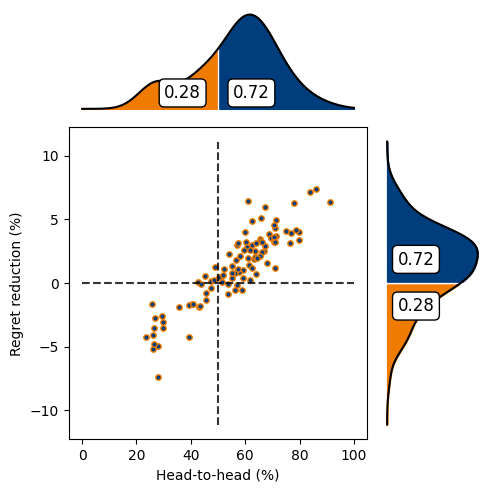

In [6]:
import Figures
Figures.figure_plot_upright(all_h2h_ddrols, all_pio_ddrols, figure_name = Result_Path_Section + '421Base_UniformW_pio', size = (5, 5), move = [-0.09, 0.06, 0.32, 0.55], ypio = 1)

#### Calibrating $\lambda$ and $\mu$

In [7]:
print( min(all_mci_ddrols), np.argmin(all_mci_ddrols) )
print( max(all_pio_ddrols), np.argmax(all_pio_ddrols) )

-0.065058059457894 76
7.405126575847085 65


In [8]:
start = time.time()
random.seed(seed)
iters = 1
x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = Data[np.argmax(all_pio_ddrols)]
np.min(z_train)

np.float64(1.2732158608288997)

In [9]:
## Solve and evaluate the OLS model
import OLS
W_ols, w0_ols, t_ols, obj_ols = OLS.ols_solver(x_train, z_train)  
import Performance
z_test_ols, y_test_ols, c_test_ols = Performance.param_prediction_and_cost_estimation(x_test, W_ols, w0_ols, thres)
c_ols_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ols, axis = 1)
pac_ols = ( np.linalg.norm(z_test_ols - z_test) )**2/len(z_test) ## prediction accuracy

y_test_opt = Performance.decision_finder(z_test_ori)
c_oracle = np.mean(np.sum(z_test_ori * y_test_opt, axis = 1))
## Solve and evaluate the DDR model
c_ddr_true_all = {}
pac_ddr_all = {}
pac_ddr_true_all = {}

mu_range = [-0.25 + i*0.05 for i in range(13)]
lamb_range = [0 + i*0.05 for i in range(81)]
import DDR
for mu in mu_range:
    for lamb in lamb_range:
        # Obtain regression parameters
        W_ddr, w0_ddr, t_ddr = DDR.ddr_solver(x_train, z_train, thres, mu, lamb)
        z_test_ddr, y_test_ddr, c_test_ddr = Performance.param_prediction_and_cost_estimation(x_test, W_ddr, w0_ddr, thres)
        c_ddr_true_all[mu,lamb] =  np.sum(np.minimum(z_test_ori,thres) * y_test_ddr, axis = 1)
        # obtain prediction accuracy
        pac_ddr_all[mu,lamb] = ( np.linalg.norm(z_test_ddr - z_test) )**2/len(z_test) ## prediction accuracy
        pac_ddr_true_all[mu,lamb] = ( np.linalg.norm(z_test_ddr - z_test_ori) )**2/len(z_test_ori) ## prediction accuracy
        
        
lamb_final = {}
for mu in mu_range:
    all_c_ddr_true = [(np.mean(c_ddr_true_all[mu, lamb])) for lamb in lamb_range]
    index = np.argmin(all_c_ddr_true)
    lamb_final_t = lamb_range[index]
    lamb_final[mu] = lamb_final_t

plotter = {}
regret = {}
pac = {}
pac_true = {}
#head_to_head
hth = {}
#mean cost improvement
mci = {}
pio = {}
lamb_min_ind = []
lamb_opt = []    
lamb_range_cut = lamb_range    
import Performance
for mu in mu_range:
    plotter[mu] = [np.mean(c_ddr_true_all[mu,lambnow]) for lambnow in lamb_range_cut]
    pac[mu] = [np.mean(pac_ddr_all[mu,lambnow]) for lambnow in lamb_range_cut]
    pac_true[mu] = [np.mean(pac_ddr_true_all[mu,lambnow]) for lambnow in lamb_range_cut]
    regret[mu] = [np.mean(c_ddr_true_all[mu,lambnow]) - c_oracle for lambnow in lamb_range_cut]
    hth[mu] = [Performance.head_2_head(c_ddr_true_all[mu,lambnow], c_ols_true) for lambnow in lamb_range_cut]
    mci[mu] = [(np.mean(c_ddr_true_all[mu,lambnow]) - np.mean(c_ols_true)) / c_oracle for lambnow in lamb_range_cut]
    pio[mu] = [( np.mean(c_ols_true) - np.mean(c_ddr_true_all[mu,lambnow]) ) / ( np.mean(c_ols_true) - c_oracle )*100 for lambnow in lamb_range_cut]
    index = np.argmin(plotter[mu])
    lamb_min_ind.append(index)
    lamb_opt.append(lamb_range[index])
    
results = [plotter, regret, hth, mci, pio, mu_range, lamb_range, lamb_opt, lamb_final, lamb_min_ind, c_ols_true, c_oracle, pac, pac_true, Data[np.argmax(all_pio_ddrols)]]
string = Result_Path_Section + '421cross_validata.pickle'
with open(string, 'wb') as f:
    pickle.dump(results, f)

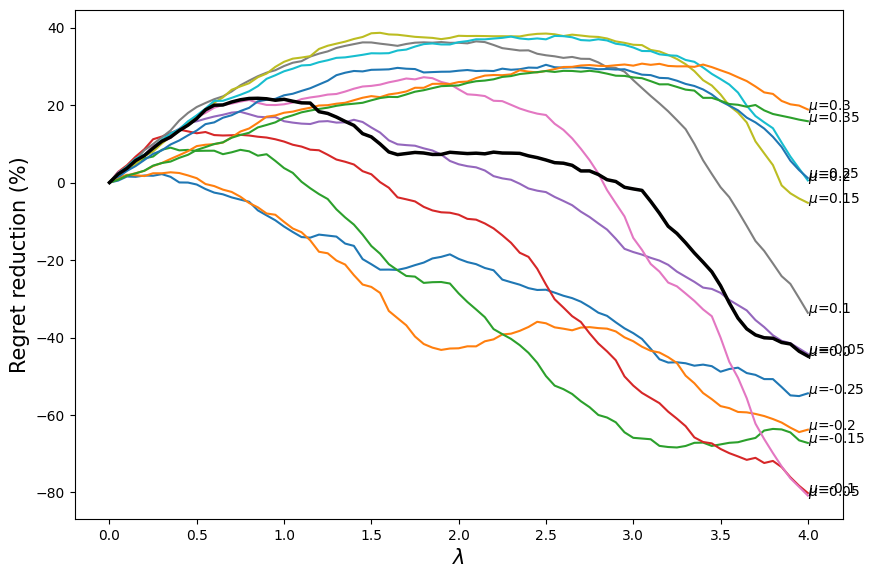

In [10]:
lamb_range_cut = lamb_range
plt.figure(figsize=(9,6))
for mu in mu_range:
    plt.plot(lamb_range_cut, pio[mu])
    plt.text(lamb_range_cut[len(lamb_range_cut)-1], pio[mu][len(lamb_range_cut)-1], '$\mu$='+ str(np.round(mu, decimals = 3)))
    
plt.plot(lamb_range_cut, pio[mu_range[5]], linewidth=2.5, color = 'black')

plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Regret reduction (%)', fontsize=15)

plt.rcParams.update({'font.size': 15})

####### Bring the marginals closer to the scatter plot and save eps file
plt.tight_layout(pad = 1)
plt.savefig(Result_Path_Section + '421baseline_calibration_pio.eps', format='eps')
plt.savefig(Result_Path_Section + '421baseline_calibration_pio.pdf', format='pdf')

### Out-of-sample fidelity 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


81


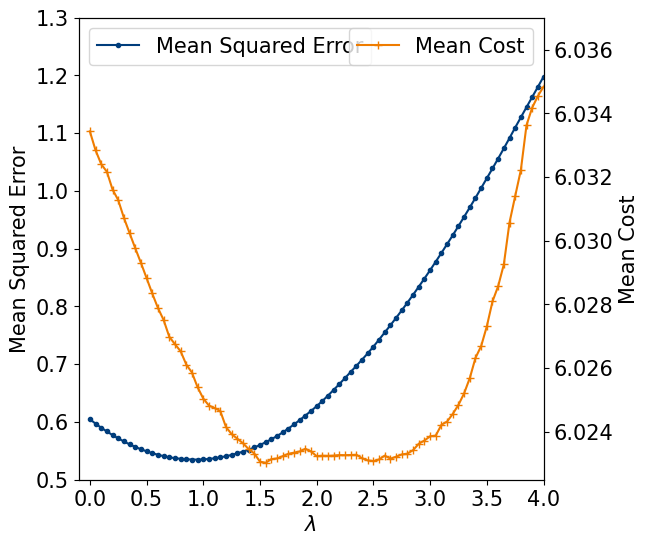

In [11]:
results = pickle.load( open( Result_Path_Section + '421cross_validata.pickle', "rb" ) )
plotter, regret, hth, mci, pio, mu_range, lamb_range, lamb_opt, lamb_final, lamb_min_ind, c_ols_true, c_oracle, pac, pac_true, data = results
lamb_range_cut = lamb_range

mu_range = [mu_range[8]]
print(len(lamb_range))
for mu in mu_range:
    fig,ax = plt.subplots(figsize=(6,6))
    ax.plot(lamb_range_cut, pac_true[mu], marker=".", label='Mean Squared Error', color='#003D7C')
    ax.set_xlabel('$\lambda$', fontsize=15)
    ax.set_ylabel('Mean Squared Error', fontsize=15) #, color='#003D7C'
    ax.set_ylim(0.50, 1.3)
    ax.legend(loc = 2)
    
    ax2=ax.twinx()
    ax2.plot(lamb_range_cut, plotter[mu], color='#EF7C00', marker="+", label='Mean Cost')
    ax2.set_ylabel("Mean Cost",fontsize=15)#, color='#EF7C00'
    ax2.set_ylim(6.0225, 6.037)
    ax2.legend(loc = 1)
#     plt.show()

plt.rcParams.update({'font.size': 12})


plt.xlim(-0.1, 4)
fig.savefig(Result_Path_Section + 'Prediction_accuracy.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_Path_Section + 'Prediction_accuracy.pdf', format='pdf', bbox_inches="tight")

In [12]:
import seaborn as sns
random.seed(seed)
p = 1
d = 1
samples_test = 100
samples_train = 50
lower = 0
upper = 1
alpha = 1
n_epsilon = 0
mis = 1
thres = 100000
## Generate data below
# x_test = data[0] #M*p
# z_test_ori = data[1] #M*d
# z_test = data[2] #M*d
# x_train = data[3] # N*p
# z_train_ori = data[4] #N*d
# z_train = data[5] # N*d
# W_star = data[6] # d*p
import Data_Simulator as Data_Simulator
W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) # o uniform, 1 sparse, 2 uniform + feature, 3 sparse + feature
data = Data_Simulator.generate_samples(p,d,samples_test, samples_train, alpha, W_star, n_epsilon = 1, mis = 1, thres = 100000, 
                     version = 1, x_dist = 'normal', e_dist = 'normal', x_low = -2, x_up = 4, x_mean = 2, 
                     x_var = 0.5, bump = 7)
x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


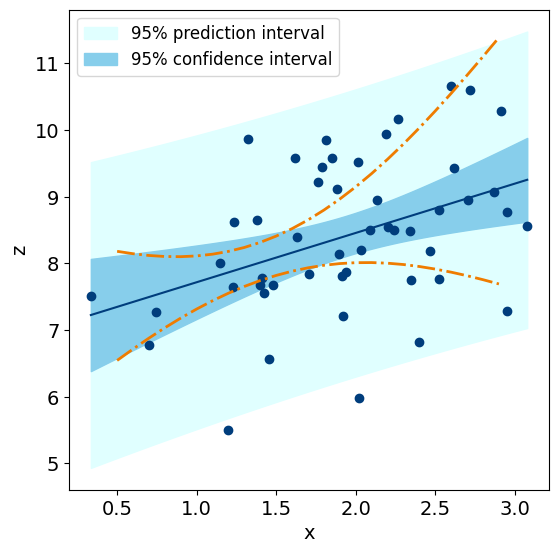

In [13]:
import scipy.stats as stats
x = x_train.T[0]
y = z_train.T[0]

slope, intercept = np.polyfit(x, y, 1)  # linear model adjustment

y_model = np.polyval([slope, intercept], x)   # modeling...

x_mean = np.mean(x)
y_mean = np.mean(y)
n = x.size                        # number of samples
m = 2                             # number of parameters
dof = n - m                       # degrees of freedom
t = stats.t.ppf(0.975, dof)       # Students statistic of interval confidence

residual = y - y_model

std_error = (np.sum(residual**2) / dof)**.5   # Standard deviation of the error

# calculating the r2
# https://www.statisticshowto.com/probability-and-statistics/coefficient-of-determination-r-squared/
# Pearson's correlation coefficient
numerator = np.sum((x - x_mean)*(y - y_mean))
denominator = ( np.sum((x - x_mean)**2) * np.sum((y - y_mean)**2) )**.5
correlation_coef = numerator / denominator
r2 = correlation_coef**2

# mean squared error
MSE = 1/n * np.sum( (y - y_model)**2 )

# to plot the adjusted model
x_line = np.linspace(np.min(x), np.max(x), 100)
y_line = np.polyval([slope, intercept], x_line)

# confidence interval
ci = t * std_error * (1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5
# predicting interval
pi = t * std_error * (1 + 1/n + (x_line - x_mean)**2 / np.sum((x - x_mean)**2))**.5  

############### Ploting
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([.1, .1, .8, .8])

ax.plot(x, y, 'o', color = '#003D7C') # royalblue
ax.plot(x_line, y_line, color = '#003D7C')
ax.fill_between(x_line, y_line + pi, y_line - pi, color = 'lightcyan', label = '95% prediction interval')
ax.fill_between(x_line, y_line + ci, y_line - ci, color = 'skyblue', label = '95% confidence interval') #skyblue

ax.set_xlabel('x')
ax.set_ylabel('z')

# rounding and position must be changed for each case and preference
a = str(np.round(intercept))
b = str(np.round(slope,2))
r2s = str(np.round(r2,2))
MSEs = str(np.round(MSE))

# ax.text(3.5, 10.0, 'y = ' + a + ' + ' + b + ' x')
# ax.text(3.5, 9.0, '$r^2$ = ' + r2s + '     MSE = ' + MSEs)

plt.legend(fontsize=12)

x1 = np.array([0.5 + 0.1*i for i in range(25)])
y1 = 1.953*(np.sin(x1-3.14159)) - 0.07127*((x1-9.7)**2) + 15.15
plt.plot(x1,y1, '-.', color = '#EF7C00', alpha = 1, linewidth = 2.0)

y2 = -1.208*(np.sin(x1-3.14159)) - 0.03607*((x1-10)**2) + 9.221
plt.plot(x1,y2, '-.', color = '#EF7C00', alpha = 1, linewidth = 2.0)
fig.savefig(Result_Path_Section + 'Prediction_intrval.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_Path_Section + 'Prediction_intrval.pdf', format='pdf', bbox_inches="tight")

### 4.2.2 Effects of d, p, N, alpha

In [14]:
def each_para_ddr_vs_ols(p, d, samples_test, samples_train, lower,upper, alpha, W_star, n_epsilon, 
                         mis, thres, mu_all, lamb_all, vs = [0,1]):
    mci_pct_final = 0
    h2h_pct_final = 0
    pio_pct_final = 0
    Results_all = {}
    import Data_Simulator
    for mu in mu_all:
        for lamb in lamb_all:
            Data = {}
            all_h2h_ddrols = []
            all_mci_ddrols = []
            all_pio_ddrols = []
            for i in range(iters):
                W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = vs[0]) # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
                # 0 mis out; 1 mis in, X N(0,1); epsilon U[-alpha, alpha]; 2 n epsilon; 3 spo+; 4 sparse X; 
                #5 X U[0,1], epsilon U[-alpha, alpha]; 6 X N(0,1), epsilon N(0,1)
                Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = vs[1], x_dist = 'uniform', e_dist = 'normal', x_low = -2, x_up = 2, x_mean = 2,
                        x_var = 0.25, bump = 7) 
#                 print(Data[i][0])
                
                lbels_ddrols, h2h_ddrols, mci_ddrols, pio_ddrols = each_iter_ddr_vs_ols(Data[i], mis, thres, mu, lamb, ypio = 1)
                all_h2h_ddrols.append(h2h_ddrols*100)
                all_mci_ddrols.append(mci_ddrols*100)
                all_pio_ddrols.append(pio_ddrols*100)
                
            Results_all[mu,lamb] = [all_h2h_ddrols, all_mci_ddrols, all_pio_ddrols]
            
            mci_pct = np.round( sum(n <= 0 for n in all_mci_ddrols)/len(all_mci_ddrols),4 )
            h2h_pct = np.round( sum(n >= 50 for n in all_h2h_ddrols)/len(all_h2h_ddrols),4 )
            pio_pct = np.round( sum(n >= 0 for n in all_pio_ddrols)/len(all_pio_ddrols),4 )
    
            if mci_pct >= mci_pct_final and h2h_pct >= h2h_pct_final:
                mci_pct_final = mci_pct
                h2h_pct_final = h2h_pct
                pio_pct_final = pio_pct
                mu_final = mu
                lamb_final = lamb
                
    return mci_pct_final, h2h_pct_final, pio_pct_final, mu_final, lamb_final, Results_all

In [15]:
start = time.time()
random.seed(seed)
mis = 1
thres = 1000000
iters = 100
samples_test = 10000
n_epsilon = 1
lower = 0
upper = 1


p = 4
d = 10
samples_train = 100
alpha = 1

mu_all = [0.25]#[-0.2 + 0.05*i for i in range(6)]
lamb_all = [0.25]#[0.1 + 0.1*i for i in range(10)]


p_range = [4 + 2*i for i in range(4)]
d_range = [5, 10, 25, 50]
N_range = [50,100,200,500,1000]
alpha_range = [0.25, 1, 2.25, 4]

Results_all_p = {}
Results_all_d = {}
Results_all_N = {}
Results_all_alpha = {}
Results_p = {}
Results_d = {}
Results_N = {}
Results_alpha = {}
##### p
for p in p_range:
    start = time.time()
    print("p = ",p)
    mci_pct_final, h2h_pct_final, pio_pct_final, mu_final, lamb_final, Results_all\
    =each_para_ddr_vs_ols(p, d, samples_test, samples_train, lower, upper, \
                          alpha, W_star, n_epsilon, mis, thres, mu_all, lamb_all, vs = [0,1])
    
    end = time.time()
    Results_p[p] = [mci_pct_final, h2h_pct_final, mu_final, lamb_final]
    Results_all_p[p] = Results_all
    
string = Result_Path_Section + '422Against_ols_p.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_p, f)

p = 4

##### d
for d in d_range:
    start = time.time()
    print("d = ",d)
    if d == 10:
        Results_d[d] = Results_p[p]
        Results_all_d[d] = Results_all_p[p]
    else:
    
        mci_pct_final, h2h_pct_final, pio_pct_final, mu_final, lamb_final, Results_all\
        =each_para_ddr_vs_ols(p, d, samples_test, samples_train, lower, upper, \
                              alpha, W_star, n_epsilon, mis, thres, mu_all, lamb_all, vs = [0,1])

        Results_d[d] = [mci_pct_final, h2h_pct_final, mu_final, lamb_final]
        Results_all_d[d] = Results_all
    end = time.time()
    
string = Result_Path_Section + '422Against_ols_d.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_d, f)
    
d = 10
##### N
for samples_train in N_range:
    print("samples_train = ",samples_train)
    start = time.time()
    if samples_train == 100:
        Results_N[samples_train] = Results_p[p]
        Results_all_N[samples_train] = Results_all_p[p]
    else:
    
        mci_pct_final, h2h_pct_final, pio_pct_final, mu_final, lamb_final, Results_all\
        =each_para_ddr_vs_ols(p, d, samples_test, samples_train, lower, upper, \
                              alpha, W_star, n_epsilon, mis, thres, mu_all, lamb_all, vs = [0,1])

        Results_N[samples_train] = [mci_pct_final, h2h_pct_final, mu_final, lamb_final]
        Results_all_N[samples_train] = Results_all
    end = time.time()
    
string = Result_Path_Section + '422Against_ols_N.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_N, f)
    
samples_train = 100

##### alpha
for alpha in alpha_range:
    print("alpha = ",alpha)
    start = time.time()
    if alpha == 1:
        Results_alpha[alpha] = Results_p[p]
        Results_all_alpha[alpha] = Results_all_p[p]
    else:
    
        mci_pct_final, h2h_pct_final, pio_pct_final, mu_final, lamb_final, Results_all\
        =each_para_ddr_vs_ols(p, d, samples_test, samples_train, lower, upper, \
                              alpha, W_star, n_epsilon, mis, thres, mu_all, lamb_all, vs = [0,1])

        Results_alpha[alpha] = [mci_pct_final, h2h_pct_final, mu_final, lamb_final]
        Results_all_alpha[alpha] = Results_all
    end = time.time()
    
string = Result_Path_Section + '422Against_ols_alpha.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_N, f)
    
alpha = 1

p =  4
p =  6
p =  8
p =  10
d =  5
d =  10
d =  25
d =  50
samples_train =  50
samples_train =  100
samples_train =  200
samples_train =  500
samples_train =  1000
alpha =  0.25
alpha =  1
alpha =  2.25
alpha =  4


In [16]:
Results = [Results_p, Results_d, Results_N, Results_alpha]
Results_all = [Results_all_p, Results_all_d, Results_all_N, Results_all_alpha]

string = Result_Path_Section + '422Aginst_ols_all.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_all, f) 
    
string = Result_Path_Section + '422Aginst_ols.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results, f) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


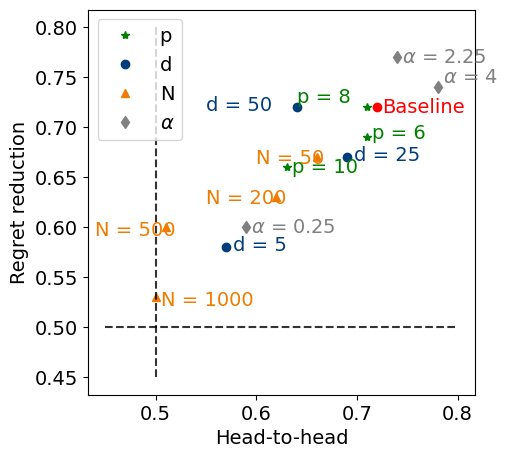

In [17]:
results = pickle.load( open( Result_Path_Section + '422Aginst_ols.pickle', "rb" ) )
p_range = [4 + 2*i for i in range(4)]
d_range = [5, 10, 25, 50]
N_range = [50,100,200,500,1000]
alpha_range = [0.25, 1, 2.25, 4]
Results_p = results[0]
Results_d = results[1]
Results_N = results[2]
Results_alpha = results[3]
mci_p = []
h2h_p = []
mci_d = []
h2h_d = []
mci_N = []
h2h_N = []
mci_alpha = []
h2h_alpha = []
for p in p_range:
    mci_p.append(Results_p[p][0])
    h2h_p.append(Results_p[p][1])
for d in d_range:
    mci_d.append(Results_d[d][0])
    h2h_d.append(Results_d[d][1])
for samples_train in N_range: 
    mci_N.append(Results_N[samples_train][0])
    h2h_N.append(Results_N[samples_train][1])
for alpha in alpha_range:
    mci_alpha.append(Results_alpha[alpha][0])
    h2h_alpha.append(Results_alpha[alpha][1])

fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p, mci_p, color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] + 0.005, mci_p[0] - 0.005, 'Baseline', color='red')
plt.text(h2h_p[1] + 0.005, mci_p[1] - 0.001, 'p = 6', color='green')
plt.text(h2h_p[2] - 0.07, mci_p[2] + 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.005, mci_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], mci_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], mci_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], mci_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.007, mci_d[0] - 0.003, 'd = 5', color='#003D7C')
# plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.007, mci_d[2] - 0.003, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] - 0.09, mci_d[3] - 0.003, 'd = 50', color='#003D7C')


plt.plot(h2h_N[0], mci_N[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[2], mci_N[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[3], mci_N[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[4], mci_N[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N[0] - 0.06, mci_N[0] - 0.006, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N[2] - 0.07, mci_N[2] - 0.006, 'N = 200', color='#EF7C00')
plt.text(h2h_N[3] - 0.07, mci_N[3] - 0.008, 'N = 500', color='#EF7C00')
plt.text(h2h_N[4] + 0.005, mci_N[4] - 0.008, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], mci_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], mci_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], mci_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] + 0.005, mci_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] + 0.005, mci_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] + 0.005, mci_alpha[3] + 0.005, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.45, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.45, 0.8, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_p[0], mci_p[0], color='red', marker = "o", linestyle = 'None')
fig.savefig(Result_Path_Section + '422_pattern_pdNalpha.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_Path_Section + '422_pattern_pdNalpha.pdf', format='pdf', bbox_inches="tight")

<a id='Part_4.2.6'></a>
### 4.2.6 With constraints
[Go back to top](#Top)

In [18]:
## Train and test are together
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 10000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 1
thres = 1000000
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
#bp = abs(xl)*upper*d
bp = 7

mu = 0.05
lamb = 0.25

a = 3
A = np.random.uniform(-2,0,(a,d))
b = np.random.uniform(-1,0,a)
    
Data = {}
all_h2h_ddrols = []
all_mci_ddrols = []
all_pio_ddrols = []
import Data_Simulator
for i in range(iters):
    W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012

    Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = ver, x_dist = x_dister, e_dist = e_dister, x_low = xl, x_up = xu, x_mean = xm,
                        x_var = xv, bump = bp)
        
    lbels_ddrols, h2h_ddrols, mci_ddrols, pio_ddrols = each_iter_ddr_vs_ols(Data[i], mis, thres, mu, lamb, ypio = 1, yconstraint = 1, A = A, b = b)
    
    all_h2h_ddrols.append(h2h_ddrols*100)
    all_mci_ddrols.append(mci_ddrols*100)
    all_pio_ddrols.append(pio_ddrols*100)
    
results = [all_h2h_ddrols, all_mci_ddrols, all_pio_ddrols, Data]
string = Result_Path_Section + '426With_constraint.pickle'
with open(string, 'wb') as f:
    pickle.dump(results, f)
end = time.time()
print(end - start)

588.5987391471863


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


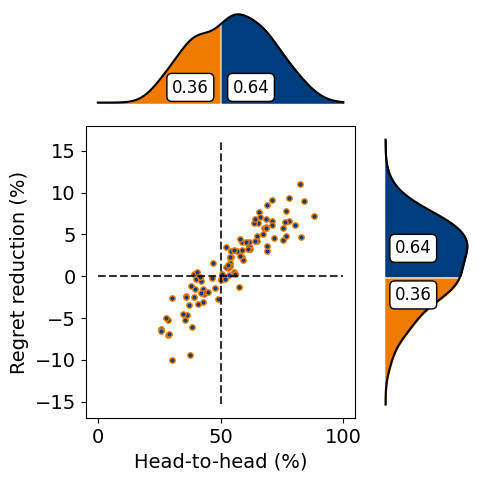

In [19]:
import Figures
Figures.figure_plot_upright(all_h2h_ddrols, all_pio_ddrols, figure_name = Result_Path_Section +'426With_constraint', yrange = [-2,4], size = (5, 5), move = [-0.08, 0.08, 0.32, 0.545], ypio = 1)

<a id='Sec_4.3'></a>
## Section 4.3: Misspecification
[Go back to top](#Top)

In [20]:
def each_iter_ddr_vs_spo_and_ols(data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ## Solve and evaluate the OLS model
    import OLS
    W_ols, w0_ols, t_ols, obj_ols = OLS.ols_solver(x_train, z_train)
    import Performance
    z_test_ols, y_test_ols, c_test_ols = Performance.param_prediction_and_cost_estimation(x_test, W_ols, w0_ols, thres)
    c_ols_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ols, axis = 1)

    y_test_opt = Performance.decision_finder(z_test_ori)
    c_oracle = np.mean(np.sum(np.minimum(z_test_ori,thres) * y_test_opt, axis = 1))
    
    ## Solve and evaluate the DDR model
    # Obtain regression parameters
    import DDR
    W_ddr, w0_ddr, t_ddr = DDR.ddr_solver(x_train, z_train, thres, mu, lamb) #******
    z_test_ddr, y_test_ddr, c_test_ddr = Performance.param_prediction_and_cost_estimation(x_test, W_ddr, w0_ddr, thres)
    c_ddr_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ddr, axis = 1)
    
    ## Solve and evaluate the SPO+ model
    # Obtain regression parameters
    y_train_opt = Performance.decision_finder(z_train) #generates the optimal y from the training costs
    import SPO
    W_spo, w0_spo, t_spo = SPO.spo_solver(x_train, z_train, y_train_opt)
    
    z_test_spo, y_test_spo, c_test_spo = Performance.param_prediction_and_cost_estimation(x_test, W_spo, w0_spo, thres)
    c_spo_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_spo, axis = 1)
    
    if ypio == 0:
#     # compares results
        lbels_ddrspo, h2h_ddrspo, mci_ddrspo = Performance.cross_compare2(c_ddr_true, c_spo_true, c_oracle)
        lbels_olsspo, h2h_olsspo, mci_olsspo = Performance.cross_compare2(c_ols_true, c_spo_true, c_oracle)
        lbels_ddrols, h2h_ddrols, mci_ddrols = Performance.cross_compare2(c_ddr_true, c_ols_true, c_oracle)
        return h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols, mci_ddrols
    else:
        # compares results plus
        lbels_ddrspo, h2h_ddrspo, mci_ddrspo, pio_ddrspo = Performance.cross_compare2plus(c_ddr_true, c_spo_true, c_oracle)
        lbels_olsspo, h2h_olsspo, mci_olsspo, pio_olsspo = Performance.cross_compare2plus(c_ols_true, c_spo_true, c_oracle)
        lbels_ddrols, h2h_ddrols, mci_ddrols, pio_ddrols = Performance.cross_compare2plus(c_ddr_true, c_ols_true, c_oracle)

        return h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols, mci_ddrols, pio_ddrspo, pio_olsspo, pio_ddrols 


In [35]:
def each_iter_ddr_vs_spo_and_ols_qua(data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
#     x_test_qua = np.concatenate( (x_test, np.square(x_test)), axis = 1 )
#     x_train_qua = np.concatenate( (x_train, np.square(x_train)), axis = 1 ) # N*(2p)
#     print(x_test.shape, x_test)
    temp = [np.multiply(x_test[:,i], x_test[:,j]).tolist() for i in range(p) for j in range(i+1)]
    x_test_qua = np.concatenate( (x_test, np.array(temp).T), axis = 1 )
    
    temp = [np.multiply(x_train[:,i], x_train[:,j]).tolist() for i in range(p) for j in range(i+1)]
    x_train_qua = np.concatenate( (x_train, np.array(temp).T), axis = 1 )
    
    ## Solve and evaluate the OLS model
    import OLS
    W_ols, w0_ols, t_ols, obj_ols = OLS.ols_solver(x_train, z_train)
    import Performance
    z_test_ols, y_test_ols, c_test_ols = Performance.param_prediction_and_cost_estimation(x_test, W_ols, w0_ols, thres)
    c_ols_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ols, axis = 1)
    
    W_ols_qua, w0_ols_qua, t_ols_qua, obj_ols_qua = OLS.ols_solver(x_train_qua, z_train)
    z_test_ols_qua, y_test_ols_qua, c_test_ols_qua = Performance.param_prediction_and_cost_estimation(x_test_qua, W_ols_qua, w0_ols_qua, thres)
    c_ols_true_qua =  np.sum(np.minimum(z_test_ori,thres) * y_test_ols_qua, axis = 1)

    y_test_opt = Performance.decision_finder(z_test_ori)
    c_oracle = np.mean(np.sum(np.minimum(z_test_ori,thres) * y_test_opt, axis = 1))
    
    ## Solve and evaluate the DDR model
    # Obtain regression parameters
    import DDR
    W_ddr, w0_ddr, t_ddr = DDR.ddr_solver(x_train, z_train, thres, mu, lamb) #******
    z_test_ddr, y_test_ddr, c_test_ddr = Performance.param_prediction_and_cost_estimation(x_test, W_ddr, w0_ddr, thres)
    c_ddr_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ddr, axis = 1)
    
    W_ddr_qua, w0_ddr_qua, t_ddr_qua = DDR.ddr_solver(x_train_qua, z_train, thres, mu, lamb) #******
    z_test_ddr_qua, y_test_ddr_qua, c_test_ddr_qua = Performance.param_prediction_and_cost_estimation(x_test_qua, W_ddr_qua, w0_ddr_qua, thres)
    c_ddr_true_qua =  np.sum(np.minimum(z_test_ori,thres) * y_test_ddr_qua, axis = 1)
    
    ## Solve and evaluate the SPO+ model
    # Obtain regression parameters
    y_train_opt = Performance.decision_finder(z_train) 
    import SPO
    W_spo, w0_spo, t_spo = SPO.spo_solver(x_train, z_train, y_train_opt)
    
    z_test_spo, y_test_spo, c_test_spo = Performance.param_prediction_and_cost_estimation(x_test, W_spo, w0_spo, thres)
    c_spo_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_spo, axis = 1)
    
    W_spo_qua, w0_spo_qua, t_spo_qua = SPO.spo_solver(x_train_qua, z_train, y_train_opt)
    
    z_test_spo_qua, y_test_spo_qua, c_test_spo_qua = Performance.param_prediction_and_cost_estimation(x_test_qua, W_spo_qua, w0_spo_qua, thres)
    c_spo_true_qua =  np.sum(np.minimum(z_test_ori,thres) * y_test_spo_qua, axis = 1)
    
    if ypio == 0:
    # compares results
        lbels_ddrspo, h2h_ddrspo, mci_ddrspo = Performance.cross_compare2(c_ddr_true_qua, c_spo_true_qua, c_oracle)
        lbels_olsspo, h2h_olsspo, mci_olsspo = Performance.cross_compare2(c_ols_true_qua, c_spo_true_qua, c_oracle)
        lbels_ddrols, h2h_ddrols, mci_ddrols = Performance.cross_compare2(c_ddr_true_qua, c_ols_true_qua, c_oracle)

        lbels_ddrqua, h2h_ddrqua, mci_ddrqua = Performance.cross_compare2(c_ddr_true_qua, c_ddr_true, c_oracle)
        lbels_olsqua, h2h_olsqua, mci_olsqua = Performance.cross_compare2(c_ols_true_qua, c_ols_true, c_oracle)
        lbels_spoqua, h2h_spoqua, mci_spoqua = Performance.cross_compare2(c_spo_true_qua, c_spo_true, c_oracle)
        return h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols, mci_ddrols, h2h_ddrqua, mci_ddrqua, h2h_olsqua, mci_olsqua, h2h_spoqua, mci_spoqua
    
    else:
        lbels_ddrspo, h2h_ddrspo, mci_ddrspo, pio_ddrspo = Performance.cross_compare2plus(c_ddr_true_qua, c_spo_true_qua, c_oracle)
        lbels_olsspo, h2h_olsspo, mci_olsspo, pio_olsspo = Performance.cross_compare2plus(c_ols_true_qua, c_spo_true_qua, c_oracle)
        lbels_ddrols, h2h_ddrols, mci_ddrols, pio_ddrols = Performance.cross_compare2plus(c_ddr_true_qua, c_ols_true_qua, c_oracle)

        lbels_ddrqua, h2h_ddrqua, mci_ddrqua, pio_ddrqua = Performance.cross_compare2plus(c_ddr_true_qua, c_ddr_true, c_oracle)
        lbels_olsqua, h2h_olsqua, mci_olsqua, pio_olsqua = Performance.cross_compare2plus(c_ols_true_qua, c_ols_true, c_oracle)
        lbels_spoqua, h2h_spoqua, mci_spoqua, pio_spoqua = Performance.cross_compare2plus(c_spo_true_qua, c_spo_true, c_oracle)
    
        return h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols, mci_ddrols, h2h_ddrqua, mci_ddrqua, h2h_olsqua, mci_olsqua, h2h_spoqua, mci_spoqua, pio_ddrspo, pio_olsspo, pio_ddrols, pio_ddrqua, pio_olsqua, pio_spoqua 

In [21]:
def figure_plot_mis(all_wins, all_mean_cost_imp, mis):
    plt.figure(figsize = (6,5))
    plt.plot(all_wins[0:3], all_mean_cost_imp[0:3],'bo', color='#003D7C')
    for i in range(3):
        plt.text(all_wins[i] - 1, all_mean_cost_imp[i] - 0.1,np.round(mis[i],1), color='#003D7C')

    plt.plot(all_wins[3], all_mean_cost_imp[3],'d', color='red')
    plt.text(all_wins[3] - 1, all_mean_cost_imp[3] - 0.1, np.round(mis[3],1), color='red')

    plt.plot(all_wins[4:7], all_mean_cost_imp[4:7],'v', color = '#EF7C00')
    for i in range(4, 7):
        plt.text(all_wins[i] + 1, all_mean_cost_imp[i] - 0.1, np.round(mis[i],1), color='#EF7C00')

    plt.plot(all_wins[7], all_mean_cost_imp[7],'v', color = '#EF7C00')
    plt.text(all_wins[7] - 1, all_mean_cost_imp[7] - 0.1, np.round(mis[7],1), color='#EF7C00')

    plt.plot(all_wins[8:12], all_mean_cost_imp[8:12],'v', color = '#EF7C00')
    for i in range(8, 12):
           plt.text(all_wins[i] - 1, all_mean_cost_imp[i] - 0.1, np.round(mis[i],1), color='#EF7C00')

    plt.vlines(50, -25, 7, linestyle="dashed", alpha = 0.8, color = 'k')
    plt.hlines(0, 40, 88, linestyle="dashed", alpha = 0.8, color = 'k')


    plt.xlabel('Head-to-head (%)', fontsize=13)
    plt.ylabel('Mean cost reduction (%)', fontsize=13)
    plt.rcParams.update({'font.size': 13})

    plt.ylim(min(all_mean_cost_imp) - 1, max(all_mean_cost_imp) + 1)
    plt.xlim(min(all_wins) - 1, max(all_wins) + 1)

In [22]:
def figure_plot_mis_pio(h2h, pio, mis):
    plt.figure(figsize = (6,5))
    plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
    for i in range(3):
        plt.text(h2h[i] - 1, pio[i] - 0.1,np.round(mis[i],1), color='#003D7C')

    plt.plot(h2h[3], pio[3],'d', color='red')
    plt.text(h2h[3] - 1, pio[3] - 0.1, np.round(mis[3],1), color='red')

    plt.plot(h2h[4:7], pio[4:7],'v', color = '#EF7C00')
    for i in range(4, 7):
        plt.text(h2h[i] + 1, pio[i] - 0.1, np.round(mis[i],1), color='#EF7C00')

    plt.plot(h2h[7], pio[7],'v', color = '#EF7C00')
    plt.text(h2h[7] - 1, pio[7] - 0.1, np.round(mis[7],1), color='#EF7C00')

    plt.plot(h2h[8:12], pio[8:12],'v', color = '#EF7C00')
    for i in range(8, 12):
           plt.text(h2h[i] - 1, pio[i] - 0.1, np.round(mis[i],1), color='#EF7C00')

    plt.vlines(50, -25, 7, linestyle="dashed", alpha = 0.8, color = 'k')
    plt.hlines(0, 40, 88, linestyle="dashed", alpha = 0.8, color = 'k')


    plt.xlabel('Head-to-head (%)', fontsize=13)
    plt.ylabel('Regret reduction (%)', fontsize=13)
    plt.rcParams.update({'font.size': 13})

    plt.ylim(min(pio) - 1, max(pio) + 1)
    plt.xlim(min(h2h) - 1, max(h2h) + 1)

<a id='Sec_4.3.1'></a>
### Section 4.3.1: DDR vs SPO (mis 1.8)
[Go back to top](#Top)

In [23]:
## Train and test are together
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 10000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 1.8
thres = 10000
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
bp = 7

mu = 0.25
lamb = 0.25

## generate samples new
# x_test = data[0] #M*p
# z_test_ori = data[1] #M*d
# z_test = data[2] #M*d
# x_train = data[3] # N*p
# z_train_ori = data[4] #N*d
# z_train = data[5] # N*d
# W_star = data[6] # d*p

Data = {}
all_h2h_ddrspo = []
all_mci_ddrspo = []
all_pio_ddrspo = []

all_h2h_olsspo = []
all_mci_olsspo = []
all_pio_olsspo = []

all_h2h_ddrols = []
all_mci_ddrols = []
all_pio_ddrols = []
import Data_Simulator
for i in range(iters):
    W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012

    Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = ver, x_dist = x_dister, e_dist = e_dister, x_low = xl, x_up = xu, x_mean = xm,
                        x_var = xv, bump = bp)
    
    h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols, mci_ddrols, pio_ddrspo, pio_olsspo, pio_ddrols\
    = each_iter_ddr_vs_spo_and_ols(Data[i], mis, thres, mu, lamb, ypio = 1)
    
    all_h2h_ddrspo.append(h2h_ddrspo*100)
    all_mci_ddrspo.append(mci_ddrspo*100)
    all_pio_ddrspo.append(pio_ddrspo*100)
    
    all_h2h_olsspo.append(h2h_olsspo*100)
    all_mci_olsspo.append(mci_olsspo*100)
    all_pio_olsspo.append(pio_olsspo*100)
    
    all_h2h_ddrols.append(h2h_ddrols*100)
    all_mci_ddrols.append(mci_ddrols*100)
    all_pio_ddrols.append(pio_ddrols*100)
    
results = [all_h2h_ddrspo, all_mci_ddrspo, all_pio_ddrspo, all_h2h_olsspo, all_mci_olsspo, all_pio_olsspo, all_h2h_ddrols, all_mci_ddrols, all_pio_ddrols]
string = Result_Path_Section + '431_ddr_spo_mis1point8.pickle'
with open(string, 'wb') as f:
    pickle.dump(results, f)
# figure_plot_upleft(all_wins, all_mean_cost_imp_oracle, figure_name, size = (5, 5), move = [-0.12, 0.04])
end = time.time()
print(end - start)

35.98004102706909


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


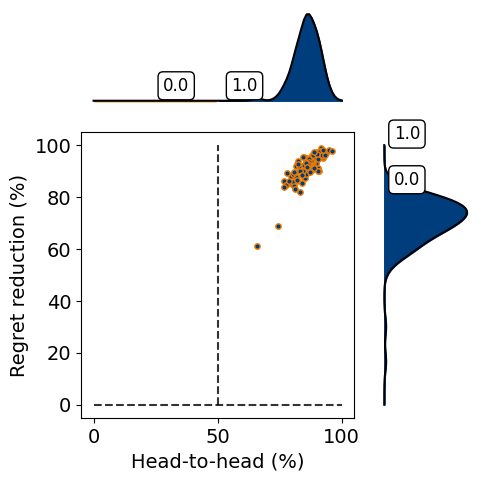

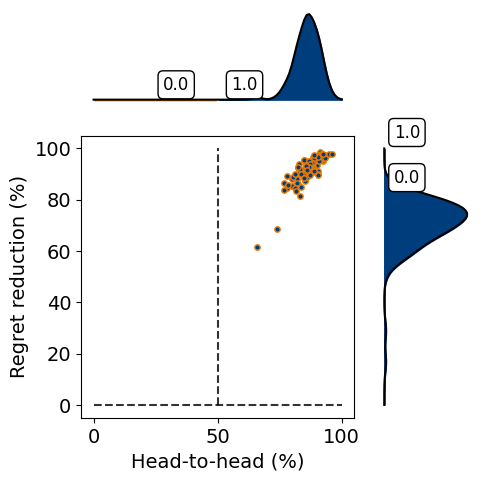

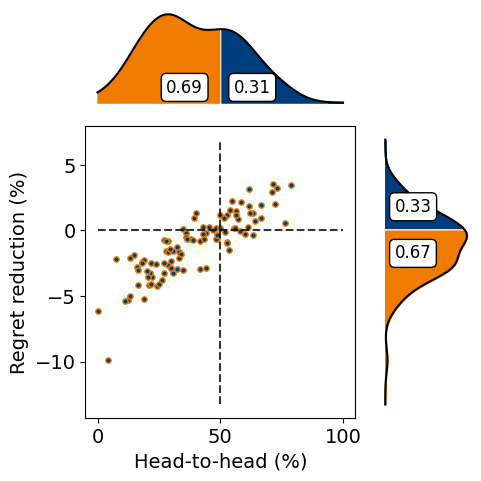

In [24]:
import Figures
Figures.figure_plot_upright(all_h2h_ddrspo, all_pio_ddrspo, figure_name = Result_Path_Section + '431_ddr_spo_mis1point8', size = (5, 5), move = [-0.11, 0.05, 0.30, 0.55], ysame = 1, yrange = [0, 100], ypio = 1)
Figures.figure_plot_upright(all_h2h_olsspo, all_pio_olsspo, figure_name = Result_Path_Section + '431_ols_spo_mis1point8', size = (5, 5), move = [-0.11, 0.05, 0.30, 0.55], ysame = 1, yrange = [0, 100], ypio = 1)
Figures.figure_plot_upright(all_h2h_ddrols, all_pio_ddrols, figure_name = Result_Path_Section + '431_ddr_ols_mis1point8', size = (5, 5), move = [-0.11, 0.05, 0.30, 0.55], ypio = 1)

<a id='Sec_4.3.2'></a>
### Section 4.3.1: DDR vs SPO (mis 3.0)
[Go back to top](#Top)

In [32]:
## the improvement is significant only when bp = 20
## if bp = 10, h2h does not have much improvement for uniformX + normalE
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 10000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 3
thres = 10000
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
#bp = abs(xl)*upper*d
bp = 7

mu = 0.25
lamb = 0.25

## generate samples new
# x_test = data[0] #M*p
# z_test_ori = data[1] #M*d
# z_test = data[2] #M*d
# x_train = data[3] # N*p
# z_train_ori = data[4] #N*d
# z_train = data[5] # N*d
# W_star = data[6] # d*p

Data = {}
all_h2h_ddrspo = []
all_mci_ddrspo = []
all_pio_ddrspo = []

all_h2h_olsspo = []
all_mci_olsspo = []
all_pio_olsspo = []

all_h2h_ddrols = []
all_mci_ddrols = []
all_pio_ddrols = []
import Data_Simulator
for i in range(iters):
    W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
    
    # 0 mis out; 1 mis in, X N(0,1); epsilon U[-alpha, alpha]; 2 n epsilon; 3 spo+; 4 sparse X; 
    #5 X U[0,1], epsilon U[-alpha, alpha]; 6 X N(0,1), epsilon N(0,1)
    Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = ver, x_dist = x_dister, e_dist = e_dister, x_low = xl, x_up = xu, x_mean = xm,
                        x_var = xv, bump = bp) 
    
    h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols, mci_ddrols, pio_ddrspo, pio_olsspo, pio_ddrols = \
    each_iter_ddr_vs_spo_and_ols(Data[i], mis, thres, mu, lamb, ypio = 1)
    
    all_h2h_ddrspo.append(h2h_ddrspo*100)
    all_mci_ddrspo.append(mci_ddrspo*100)
    all_pio_ddrspo.append(pio_ddrspo*100)
    
    all_h2h_olsspo.append(h2h_olsspo*100)
    all_mci_olsspo.append(mci_olsspo*100)
    all_pio_olsspo.append(pio_olsspo*100)
    
    all_h2h_ddrols.append(h2h_ddrols*100)
    all_mci_ddrols.append(mci_ddrols*100)
    all_pio_ddrols.append(pio_ddrols*100)
    
results = [all_h2h_ddrspo, all_mci_ddrspo, all_pio_ddrspo, all_h2h_olsspo, all_mci_olsspo, all_pio_olsspo, all_h2h_ddrols, all_mci_ddrols, all_pio_ddrols]
string = Result_Path_Section + '411_ddr_spo.pickle'
with open(string, 'wb') as f:
    pickle.dump(results, f)
# figure_plot_upleft(all_wins, all_mean_cost_imp_oracle, figure_name, size = (5, 5), move = [-0.12, 0.04])
end = time.time()
print(end - start)

34.890753984451294


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


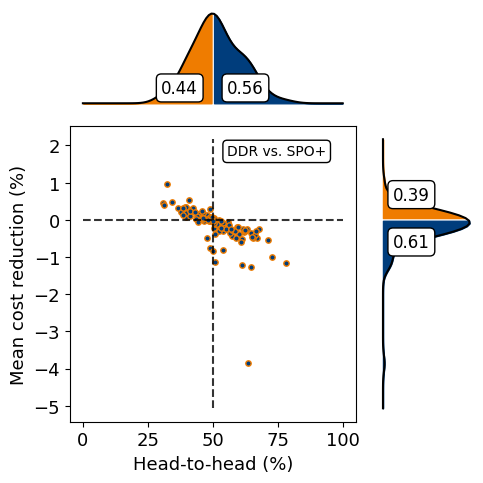

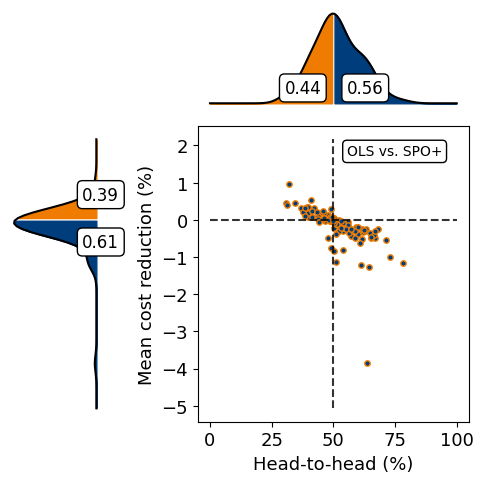

In [33]:
import Figures
Figures.figure_plot_upright(all_h2h_ddrspo, all_mci_ddrspo, figure_name = Result_Path_Section + '411_ddr_spo_mis3', size = (5, 5), move = [-0.11, 0.05, 0.32, 0.55], sublabel = 'DDR vs. SPO+')

Figures.figure_plot_upleft(all_h2h_olsspo, all_mci_olsspo, figure_name = Result_Path_Section + '411_ols_spo_mis3', size = (5, 5), move = [-0.11, 0.05, 0.32, 0.55], sublabel = 'OLS vs. SPO+')

In [36]:
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 10000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 3
thres = 10000
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
#bp = abs(xl)*upper*d
bp = 7

mu = 0.25
lamb = 0.25

## generate samples new
# x_test = data[0] #M*p
# z_test_ori = data[1] #M*d
# z_test = data[2] #M*d
# x_train = data[3] # N*p
# z_train_ori = data[4] #N*d
# z_train = data[5] # N*d
# W_star = data[6] # d*p

Data = {}
all_h2h_ddrspo = []
all_mci_ddrspo = []
all_pio_ddrspo = []

all_h2h_olsspo = []
all_mci_olsspo = []
all_pio_olsspo = []

all_h2h_ddrols = []
all_mci_ddrols = []
all_pio_ddrols = []
####
all_h2h_ddrqua = []
all_mci_ddrqua = []
all_pio_ddrqua = []

all_h2h_olsqua = []
all_mci_olsqua = []
all_pio_olsqua = []

all_h2h_spoqua = []
all_mci_spoqua = []
all_pio_spoqua = []
import Data_Simulator
for i in range(iters):
    W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
    
    Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = ver, x_dist = x_dister, e_dist = e_dister, x_low = xl, x_up = xu, x_mean = xm,
                        x_var = xv, bump = bp) 

    
    h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols, mci_ddrols, \
    h2h_ddrqua, mci_ddrqua, h2h_olsqua, mci_olsqua, h2h_spoqua, mci_spoqua, \
    pio_ddrspo, pio_olsspo, pio_ddrols, pio_ddrqua, pio_olsqua, pio_spoqua\
    = each_iter_ddr_vs_spo_and_ols_qua(Data[i], mis, thres, mu, lamb, ypio = 1)
    
    all_h2h_ddrspo.append(h2h_ddrspo*100)
    all_mci_ddrspo.append(mci_ddrspo*100)
    all_pio_ddrspo.append(pio_ddrspo*100)
    
    all_h2h_olsspo.append(h2h_olsspo*100)
    all_mci_olsspo.append(mci_olsspo*100)
    all_pio_olsspo.append(pio_olsspo*100)
    
    all_h2h_ddrols.append(h2h_ddrols*100)
    all_mci_ddrols.append(mci_ddrols*100)
    all_pio_ddrols.append(pio_ddrols*100)
    
    ##
    all_h2h_ddrqua.append(h2h_ddrqua*100)
    all_mci_ddrqua.append(mci_ddrqua*100)
    all_pio_ddrqua.append(pio_ddrqua*100)
    
    all_h2h_olsqua.append(h2h_olsqua*100)
    all_mci_olsqua.append(mci_olsqua*100)
    all_pio_olsqua.append(pio_olsqua*100)
    
    all_h2h_spoqua.append(h2h_spoqua*100)
    all_mci_spoqua.append(mci_spoqua*100)
    all_pio_spoqua.append(pio_spoqua*100)
    
results = [all_h2h_ddrspo, all_mci_ddrspo, all_h2h_olsspo, all_mci_olsspo, all_h2h_ddrols, all_mci_ddrols,\
          all_h2h_ddrqua, all_mci_ddrqua, all_h2h_olsqua, all_mci_olsqua, all_h2h_spoqua, all_mci_spoqua,\
          all_pio_ddrspo, all_pio_olsspo, all_pio_ddrols, all_pio_ddrqua, all_pio_olsqua, all_pio_spoqua]
string = Result_Path_Section + '411_ddr_spo_qua.pickle'
with open(string, 'wb') as f:
    pickle.dump(results, f)
# figure_plot_upleft(all_wins, all_mean_cost_imp_oracle, figure_name, size = (5, 5), move = [-0.12, 0.04])
end = time.time()
print(end - start)

121.86936235427856


In [ ]:
all_h2h_ddrspo, all_mci_ddrspo, all_h2h_olsspo, all_mci_olsspo, all_h2h_ddrols, all_mci_ddrols,\
all_h2h_ddrqua, all_mci_ddrqua, all_h2h_olsqua, all_mci_olsqua, all_h2h_spoqua, all_mci_spoqua,\
all_pio_ddrspo, all_pio_olsspo, all_pio_ddrols, all_pio_ddrqua, all_pio_olsqua, all_pio_spoqua = pickle.load( open( '411_ddr_spo_qua.pickle', "rb" ) )

In [ ]:
import Figures
Figures.figure_plot_upright(all_h2h_ddrspo, all_mci_ddrspo, figure_name = '411_ddr_qua_spo_qua', size = (5, 5), move = [-0.12, 0.04, 0.31, 0.55], sublabel = 'DDR vs. SPO+')

Figures.figure_plot_upleft(all_h2h_olsspo, all_mci_olsspo, figure_name = '411_ols_qua_spo_qua', size = (5, 5), move = [-0.12, 0.04, 0.30, 0.55], sublabel = 'OLS vs. SPO+')

<a id='Sec_4.3.2'></a>
### Section 4.3.2: DDR/OLS vs SPO (all mis)
[Go back to top](#Top)

In [28]:
# random.seed(3)
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 10000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 1
thres = 100000000
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
#bp = abs(xl)*upper*d
bp = 7

mu = 0.25
lamb = 0.25

mis_all = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]
# mis_all = [0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0]

all_h2h_ddrspo = []
all_mci_ddrspo = []
all_pio_ddrspo = []

all_h2h_ddrols = []
all_mci_ddrols = []
all_pio_ddrols = []

all_h2h_olsspo = []
all_mci_olsspo = []
all_pio_olsspo = []
import Data_Simulator
for mis in mis_all:
    Data = {}
    mis_h2h_ddrspo = []
    mis_mci_ddrspo = []
    mis_pio_ddrspo = []
    
    mis_h2h_olsspo = []
    mis_mci_olsspo = []
    mis_pio_olsspo = []
    
    mis_h2h_ddrols = []
    mis_mci_ddrols = []
    mis_pio_ddrols = []
    for i in range(iters):
        W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) # o uniform, 1 sparse, 2 uniform + feature, 3 sparse + feature
        Data[mis,i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                                           version = 1, x_dist = x_dister, e_dist = e_dister, x_low = xl, 
                                           x_up = xu, x_mean = xm, x_var = xv, bump = bp)
        h2h_ddrspo, mci_ddrspo, h2h_olsspo, mci_olsspo, h2h_ddrols,\
        mci_ddrols, pio_ddrspo, pio_olsspo, pio_ddrols  = each_iter_ddr_vs_spo_and_ols(Data[mis,i], mis, thres, mu, lamb, ypio = 1)
                
        mis_h2h_ddrspo.append(h2h_ddrspo*100)
        mis_mci_ddrspo.append(mci_ddrspo*100)
        mis_pio_ddrspo.append(pio_ddrspo*100)
        
        mis_h2h_olsspo.append(h2h_olsspo*100)
        mis_mci_olsspo.append(mci_olsspo*100)
        mis_pio_olsspo.append(pio_olsspo*100)

        mis_h2h_ddrols.append(h2h_ddrols*100)
        mis_mci_ddrols.append(mci_ddrols*100)
        mis_pio_ddrols.append(pio_ddrols*100)
    
#     print(mis_mci_ddrspo)
    all_h2h_ddrspo.append(np.nanmean(mis_h2h_ddrspo))
    all_mci_ddrspo.append(np.nanmean(mis_mci_ddrspo))
    all_pio_ddrspo.append(np.nanmean(mis_pio_ddrspo))
    
    all_h2h_olsspo.append(np.nanmean(mis_h2h_olsspo))
    all_mci_olsspo.append(np.nanmean(mis_mci_olsspo))
    all_pio_olsspo.append(np.nanmean(mis_pio_olsspo))
    
    all_h2h_ddrols.append(np.nanmean(mis_h2h_ddrols))
    all_mci_ddrols.append(np.nanmean(mis_mci_ddrols))  
    all_pio_ddrols.append(np.nanmean(mis_pio_ddrols))  
    
results = [all_h2h_ddrspo, all_mci_ddrspo, all_pio_ddrspo, 
           all_h2h_olsspo, all_mci_olsspo, all_pio_olsspo, 
           all_h2h_ddrols, all_mci_ddrols, all_pio_ddrols]
string = Result_Path_Section + '430Misspecification.pickle'
with open(string, 'wb') as f: 
    pickle.dump(results, f)

/Users/zhangxun/Dropbox/Research/Decision_Driven_Regularization/Code_MacBook/Decision_Driven_Regularization/JOC_R1/Third_Version_Setting2/Data_Simulator.py:52: RuntimeWarning: invalid value encountered in power
  z_test_ori = np.power(np.dot(x_test, W_star.T) + bump * np.ones((samples_test, d)), mis)


In [29]:
results = pickle.load( open( Result_Path_Section + '430Misspecification.pickle', "rb" ) )
all_h2h_ddrspo, all_mci_ddrspo, all_pio_ddrspo,\
all_h2h_olsspo, all_mci_olsspo, all_pio_olsspo,\
all_h2h_ddrols, all_mci_ddrols, all_pio_ddrols = results

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_58129/3749182833.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


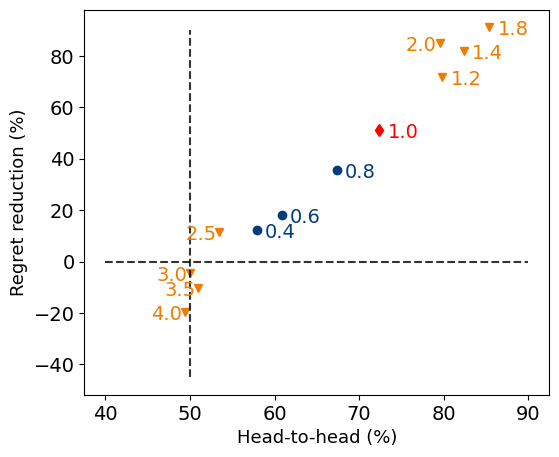

In [30]:
mis_all = [0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.8, 2.0, 2.5, 3.0, 3.5, 4.0]
h2h = all_h2h_ddrspo
pio = all_pio_ddrspo
mis = mis_all
plt.figure(figsize = (6,5))
plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
for i in range(3):
    plt.text(h2h[i] + 1, pio[i] - 3,np.round(mis[i],1), color='#003D7C')

plt.plot(h2h[3], pio[3],'d', color='red')
plt.text(h2h[3] + 1, pio[3] - 3, np.round(mis[3],1), color='red')

plt.plot(h2h[4:7], pio[4:7],'v', color = '#EF7C00')
for i in range(4, 7):
    plt.text(h2h[i] + 1, pio[i] - 3, np.round(mis[i],1), color='#EF7C00')

plt.plot(h2h[7], pio[7],'v', color = '#EF7C00')
plt.text(h2h[7] - 4, pio[7] - 3, np.round(mis[7],1), color='#EF7C00')

plt.plot(h2h[8:12], pio[8:12],'v', color = '#EF7C00')
for i in range(8, 12):
       plt.text(h2h[i] - 4, pio[i] - 3, np.round(mis[i],1), color='#EF7C00')

plt.vlines(50, -45, 90, linestyle="dashed", alpha = 0.8, color = 'k')
plt.hlines(0, 40, 90, linestyle="dashed", alpha = 0.8, color = 'k')


plt.xlabel('Head-to-head (%)', fontsize=13)
plt.ylabel('Regret reduction (%)', fontsize=13)
plt.rcParams.update({'font.size': 13})

plt.savefig(Result_Path_Section + '430_mis_ddrspo.eps', format='eps', bbox_inches="tight")

/var/folders/m2/j39mx9854cbb70jqvn7cjcqh0000gn/T/ipykernel_58129/1656960497.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


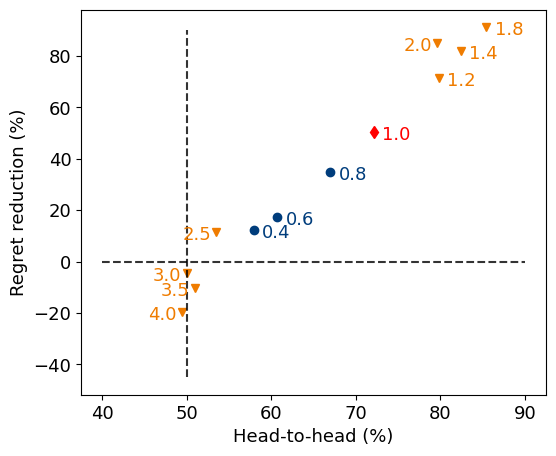

In [31]:
h2h = all_h2h_olsspo
pio = all_pio_olsspo
mis = mis_all
plt.figure(figsize = (6,5))
plt.plot(h2h[0:3], pio[0:3],'bo', color='#003D7C')
for i in range(3):
    plt.text(h2h[i] + 1, pio[i] - 3,np.round(mis[i],1), color='#003D7C')

plt.plot(h2h[3], pio[3],'d', color='red')
plt.text(h2h[3] + 1, pio[3] - 3, np.round(mis[3],1), color='red')

plt.plot(h2h[4:7], pio[4:7],'v', color = '#EF7C00')
for i in range(4, 7):
    plt.text(h2h[i] + 1, pio[i] - 3, np.round(mis[i],1), color='#EF7C00')

plt.plot(h2h[7], pio[7],'v', color = '#EF7C00')
plt.text(h2h[7] - 4, pio[7] - 3, np.round(mis[7],1), color='#EF7C00')

plt.plot(h2h[8:12], pio[8:12],'v', color = '#EF7C00')
for i in range(8, 12):
       plt.text(h2h[i] - 4, pio[i] - 3, np.round(mis[i],1), color='#EF7C00')

plt.vlines(50, -45, 90, linestyle="dashed", alpha = 0.8, color = 'k')
plt.hlines(0, 40, 90, linestyle="dashed", alpha = 0.8, color = 'k')


plt.xlabel('Head-to-head (%)', fontsize=13)
plt.ylabel('Regret reduction (%)', fontsize=13)
plt.rcParams.update({'font.size': 13})

plt.savefig(Result_Path_Section + '430_mis_olsspo.eps', format='eps', bbox_inches="tight")

### Against Lasso and Ridge

In [37]:
def each_iter_vs_lasso_ridge(data, mis, thres, mu, lamb, ypio = 0):
    x_test, z_test_ori, z_test, x_train, z_train_ori, z_train, W_star = data
    ## Solve and evaluate the OLS model
    import OLS
    W_ols, w0_ols, t_ols, obj_ols = OLS.ols_solver(x_train, z_train)
    import Performance
    z_test_ols, y_test_ols, c_test_ols = Performance.param_prediction_and_cost_estimation(x_test, W_ols, w0_ols, thres)
    c_ols_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ols, axis = 1)
    
    z_train_ols, y_train_ols, c_train_ols = Performance.param_prediction_and_cost_estimation(x_train, W_ols, w0_ols, thres)
    pac_ols = np.linalg.norm(z_test_ols - z_test)/len(z_test) # prediction accuracy
    
    ## Solve and evaluate the LASSO model
    W_lso, w0_lso, t_lso = OLS.lasso_solver(x_train, z_train)
    z_test_lso, y_test_lso, c_test_lso = Performance.param_prediction_and_cost_estimation(x_test, W_lso, w0_lso, thres)
    c_lso_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_lso, axis = 1)
    
    z_train_lso, y_train_lso, c_train_lso = Performance.param_prediction_and_cost_estimation(x_train, W_lso, w0_lso, thres)
    pac_lso = np.linalg.norm(z_test_lso - z_test)/len(z_test) # prediction accuracy
    
    ## Solve and evaluate the LASSO model
    W_rgi, w0_rgi, t_rgi = OLS.ridge_solver(x_train, z_train)
    z_test_rgi, y_test_rgi, c_test_rgi = Performance.param_prediction_and_cost_estimation(x_test, W_rgi, w0_rgi, thres)
    c_rgi_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_rgi, axis = 1)
    
    z_train_rgi, y_train_rgi, c_train_rgi = Performance.param_prediction_and_cost_estimation(x_train, W_rgi, w0_rgi, thres)
    pac_rgi = np.linalg.norm(z_test_rgi - z_test)/len(z_test) # prediction accuracy
    
    
    y_test_opt = Performance.decision_finder(z_test_ori)
    c_oracle = np.mean(np.sum(np.minimum(z_test_ori,thres) * y_test_opt, axis = 1))
    
    ## Solve and evaluate the DDR model
    # Obtain regression parameters
    import DDR
    W_ddr, w0_ddr, t_ddr = DDR.ddr_solver(x_train, z_train, thres, mu, lamb) #******
    z_test_ddr, y_test_ddr, c_test_ddr = Performance.param_prediction_and_cost_estimation(x_test, W_ddr, w0_ddr, thres)
    c_ddr_true =  np.sum(np.minimum(z_test_ori,thres) * y_test_ddr, axis = 1)
    
    z_train_ddr, y_train_ddr, c_train_ddr = Performance.param_prediction_and_cost_estimation(x_train, W_ddr, w0_ddr, thres)
    pac_ddr = np.linalg.norm(z_test_ddr - z_test)/len(z_test) # prediction accuracy
    
#     print(c_rgi_true - c_ddr_true)
    
    if ypio == 0:
        # compares results
        lbels_lsools, h2h_lsools, mci_lsools = Performance.cross_compare2(c_lso_true, c_ols_true, c_oracle)
        lbels_rgiols, h2h_rgiols, mci_rgiols = Performance.cross_compare2(c_rgi_true, c_ols_true, c_oracle)

        lbels_lsoddr, h2h_lsoddr, mci_lsoddr = Performance.cross_compare2(c_lso_true, c_ddr_true, c_oracle)
        lbels_rgiddr, h2h_rgiddr, mci_rgiddr = Performance.cross_compare2(c_rgi_true, c_ddr_true, c_oracle)

        return h2h_lsools, mci_lsools, h2h_rgiols, mci_rgiols, h2h_lsoddr, mci_lsoddr, h2h_rgiddr, mci_rgiddr
    
    else:
        # compares results
        lbels_lsools, h2h_lsools, mci_lsools, pio_lsools = Performance.cross_compare2plus(c_lso_true, c_ols_true, c_oracle)
        lbels_rgiols, h2h_rgiols, mci_rgiols, pio_rgiols = Performance.cross_compare2plus(c_rgi_true, c_ols_true, c_oracle)

        lbels_lsoddr, h2h_lsoddr, mci_lsoddr, pio_lsoddr = Performance.cross_compare2plus(c_lso_true, c_ddr_true, c_oracle)
        lbels_rgiddr, h2h_rgiddr, mci_rgiddr, pio_rgiddr = Performance.cross_compare2plus(c_rgi_true, c_ddr_true, c_oracle)

        return h2h_lsools, mci_lsools, h2h_rgiols, mci_rgiols, h2h_lsoddr, mci_lsoddr, h2h_rgiddr, mci_rgiddr, pio_lsools, pio_rgiols, pio_lsoddr, pio_rgiddr, pac_ols, pac_lso, pac_rgi, pac_ddr


In [38]:
## Train and test are together
start = time.time()
random.seed(seed)
iters = 100
p = 4
d = 10
samples_test = 10000
samples_train = 100
lower = 0
upper = 1
alpha = 1
n_epsilon = 1
mis = 1
thres = 10000
ver = 1
x_dister = 'uniform'
e_dister = 'normal'
xl = -2
xu = 2
xm = 2
xv = 0.25
#bp = abs(xl)*upper*d
bp = 7

mu = 0.25
lamb = 0.25


Data = {}
all_h2h_lsools = []
all_mci_lsools = []
all_pio_lsools = []
all_h2h_rgiols = []
all_mci_rgiols = []
all_pio_rgiols = []

all_h2h_lsoddr = []
all_mci_lsoddr = []
all_pio_lsoddr = []
all_h2h_rgiddr = []
all_mci_rgiddr = []
all_pio_rgiddr = []

all_pac_ols = [] 
all_pac_lso = []
all_pac_rgi = [] 
all_pac_ddr = []
import Data_Simulator
for i in range(iters):
    # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
    W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = 0) 
    
    Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                        version = ver, x_dist = x_dister, e_dist = e_dister, x_low = xl, x_up = xu, x_mean = xm,
                        x_var = xv, bump = bp) 
    
    h2h_lsools, mci_lsools, h2h_rgiols, mci_rgiols, h2h_lsoddr, mci_lsoddr, h2h_rgiddr, mci_rgiddr,\
    pio_lsools, pio_rgiols, pio_lsoddr, pio_rgiddr,\
    pac_ols, pac_lso, pac_rgi, pac_ddr = each_iter_vs_lasso_ridge(Data[i], mis, thres, mu, lamb, ypio = 1)
    
    all_h2h_lsools.append(h2h_lsools*100)
    all_mci_lsools.append(mci_lsools*100)
    all_pio_lsools.append(pio_lsools*100)
    
    all_h2h_rgiols.append(h2h_rgiols*100)
    all_mci_rgiols.append(mci_rgiols*100)
    all_pio_rgiols.append(pio_rgiols*100)
    
    all_h2h_lsoddr.append(h2h_lsoddr*100)
    all_mci_lsoddr.append(mci_lsoddr*100)
    all_pio_lsoddr.append(pio_lsoddr*100)
    
    all_h2h_rgiddr.append(h2h_rgiddr*100)
    all_mci_rgiddr.append(mci_rgiddr*100)
    all_pio_rgiddr.append(pio_rgiddr*100)
    
    all_pac_ols.append(pac_ols)
    all_pac_lso.append(pac_lso)
    all_pac_rgi.append(pac_rgi)
    all_pac_ddr.append(pac_ddr)
    
results = [all_h2h_lsools, all_mci_lsools, all_h2h_rgiols, all_mci_rgiols, all_h2h_lsoddr,\
           all_mci_lsoddr, all_h2h_lsoddr, all_mci_lsoddr,\
           all_pio_lsools, all_pio_rgiols, all_pio_lsoddr, all_pio_lsoddr,\
           all_pac_ols, all_pac_lso, all_pac_rgi, all_pac_ddr]
string = Result_Path_Section + '413lso_rgi_vs_ols_and_ddr.pickle'
with open(string, 'wb') as f:
    pickle.dump(results, f)
end = time.time()
print(end - start)

120.3897020816803


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


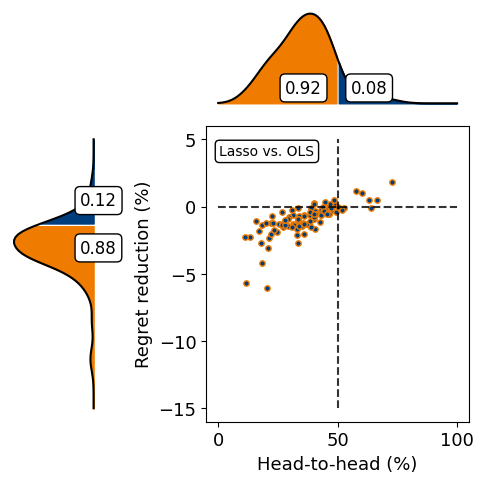

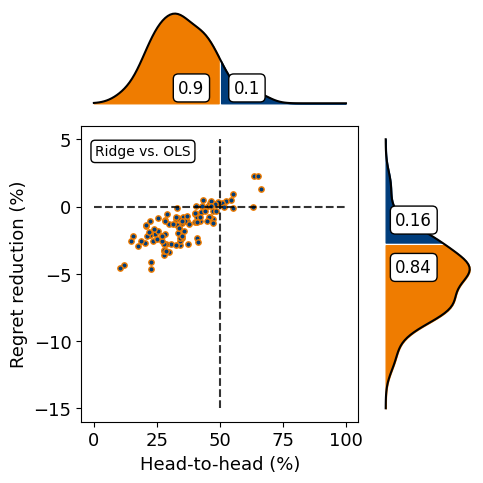

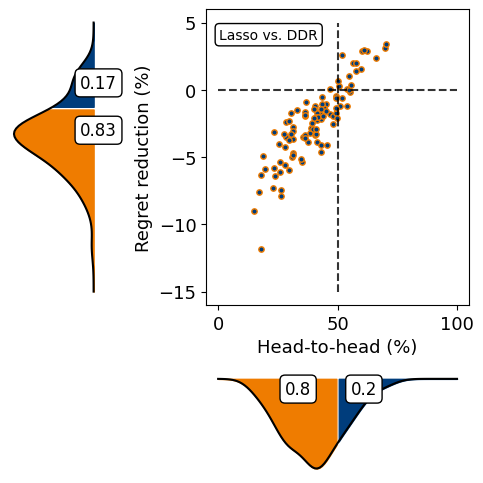

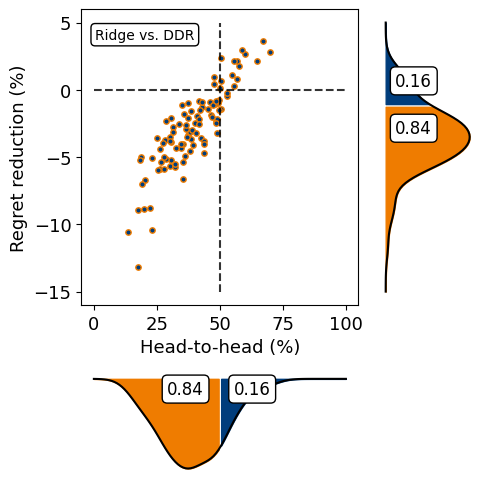

In [39]:
import Figures
Figures.figure_plot_upleft(all_h2h_lsools, all_pio_lsools, figure_name = Result_Path_Section + '413lsools_pio', size = (5, 5), move = [-0.11, 0.05, 0.30, 0.55], ysame = 1, yrange = [-15,5], sublabel = 'Lasso vs. OLS', ypio = 1)
Figures.figure_plot_upright(all_h2h_rgiols, all_pio_rgiols, figure_name = Result_Path_Section + '413rgiols_pio', size = (5, 5), move = [-0.11, 0.05, 0.35, 0.55], ysame = 1, yrange = [-15,5], sublabel = 'Ridge vs. OLS', ypio = 1)
Figures.figure_plot_lowleft(all_h2h_lsoddr, all_pio_lsoddr, figure_name = Result_Path_Section + '413lsoddr_pio', size = (5, 5), move = [-0.11, 0.05, 0.30, 0.55], ysame = 1, yrange = [-15,5], sublabel = 'Lasso vs. DDR', ypio = 1)
Figures.figure_plot_lowright(all_h2h_rgiddr, all_pio_rgiddr, figure_name = Result_Path_Section + '413rgiddr_pio', size = (5, 5), move = [-0.11, 0.05, 0.31, 0.55], ysame = 1, yrange = [-15,5], sublabel = 'Ridge vs. DDR', ypio = 1)

In [43]:
def each_para_ddr_ols_vs_lasso_ridge(p, d, samples_test, samples_train, lower,upper, alpha, W_star, n_epsilon, 
                         mis, thres, mu, lamb, vs = [0,1]):
    Data = {}
    all_h2h_lsools = []
#     all_mci_lsools = []
    all_pio_lsools = []

    all_h2h_lsoddr = []
#     all_mci_lsoddr = []
    all_pio_lsoddr = []

    all_h2h_rgiols = []
#     all_mci_rgiols = []
    all_pio_rgiols = []

    all_h2h_rgiddr = []
#     all_mci_rgiddr = []
    import Data_Simulator
    all_pio_rgiddr = []
    for i in range(iters):
        W_star = Data_Simulator.generate_truth(lower, upper, p, d, version = vs[0]) # o uniform, 1 binary, 2 uniform + feature, 3 binary + feature, 4 sparse, 5 012
        # 0 mis out; 1 mis in, X N(0,1); epsilon U[-alpha, alpha]; 2 n epsilon; 3 spo+; 4 sparse X; 
        #5 X U[0,1], epsilon U[-alpha, alpha]; 6 X N(0,1), epsilon N(0,1)
        Data[i] = Data_Simulator.generate_samples(p, d, samples_test, samples_train, alpha, W_star, n_epsilon, mis, thres, 
                version = vs[1], x_dist = 'uniform', e_dist = 'normal', x_low = -2, x_up = 2, x_mean = 2,
                x_var = 0.25, bump = 7) 
#                 print(Data[i][0])

        h2h_lsools, mci_lsools, h2h_rgiols, mci_rgiols, h2h_lsoddr, mci_lsoddr, h2h_rgiddr,\
        mci_rgiddr, pio_lsools, pio_rgiols, pio_lsoddr, pio_rgiddr, pac_ols, pac_lso, pac_rgi, pac_ddr\
        = each_iter_vs_lasso_ridge(Data[i], mis, thres, mu, lamb, ypio = 1)

        all_h2h_lsools.append(h2h_lsools*100)
        all_pio_lsools.append(pio_lsools*100)

        all_h2h_rgiols.append(h2h_rgiols*100)
        all_pio_rgiols.append(pio_rgiols*100)

        all_h2h_lsoddr.append(h2h_lsoddr*100)
        all_pio_lsoddr.append(pio_lsoddr*100)

        all_h2h_rgiddr.append(h2h_rgiddr*100)
        all_pio_rgiddr.append(pio_rgiddr*100)
        
        h2h_lsools_pct = np.round( sum(n >= 50 for n in all_h2h_lsools)/len(all_h2h_lsools),4 )
        pio_lsools_pct = np.round( sum(n >= 0 and n <= 100 for n in all_pio_lsools)/len(all_pio_lsools),4 )
        
        h2h_rgiols_pct = np.round( sum(n >= 50 for n in all_h2h_rgiols)/len(all_h2h_rgiols),4 )
        pio_rgiols_pct = np.round( sum(n >= 0 and n <= 100 for n in all_pio_rgiols)/len(all_pio_rgiols),4 )
        
        h2h_lsoddr_pct = np.round( sum(n >= 50 for n in all_h2h_lsoddr)/len(all_h2h_lsoddr),4 )
        pio_lsoddr_pct = np.round( sum(n >= 0 and n <= 100 for n in all_pio_lsoddr)/len(all_pio_lsoddr),4 )
        
        h2h_rgiddr_pct = np.round( sum(n >= 50 for n in all_h2h_rgiddr)/len(all_h2h_rgiddr),4 )
        pio_rgiddr_pct = np.round( sum(n >= 0 and n <= 100 for n in all_pio_rgiddr)/len(all_pio_rgiddr),4 )

    Results_all = [all_h2h_lsools, all_pio_lsools, all_h2h_rgiols, all_pio_rgiols, 
                            all_h2h_lsoddr, all_pio_lsoddr, all_h2h_rgiddr, all_pio_rgiddr]
                
    return h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct, h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct, Results_all

In [44]:
start = time.time()
random.seed(seed)
mis = 1
thres = 1000000
iters = 100
samples_test = 10000
n_epsilon = 1
lower = 0
upper = 1


p = 4
d = 10
samples_train = 100
alpha = 1

mu = 0.25
lamb = 0.25


p_range = [4 + 2*i for i in range(4)]
d_range = [5, 10, 25, 50]
N_range = [50,100,200,500,1000]
alpha_range = [0.25, 1, 2.25, 4]

Results_all_p = {}
Results_all_d = {}
Results_all_N = {}
Results_all_alpha = {}
Results_p = {}
Results_d = {}
Results_N = {}
Results_alpha = {}
##### p
for p in p_range:
    start = time.time()
    print("p=",p)
    h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
    h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct, Results_all\
    =each_para_ddr_ols_vs_lasso_ridge(p, d, samples_test, samples_train, lower, upper, \
                          alpha, W_star, n_epsilon, mis, thres, mu, lamb, vs = [0,1])
    
    end = time.time()
    Results_p[p] = [h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
                    h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct]
    Results_all_p[p] = Results_all
    
string = Result_Path_Section + '414Against_lsorgi_p.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_p, f)

p = 4

##### d
for d in d_range:
    start = time.time()
    print("d = ",d)
    if d == 10:
        Results_d[d] = Results_p[p]
        Results_all_d[d] = Results_all_p[p]
    else:
    
        h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
        h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct, Results_all\
        =each_para_ddr_ols_vs_lasso_ridge(p, d, samples_test, samples_train, lower, upper, \
                              alpha, W_star, n_epsilon, mis, thres, mu, lamb, vs = [0,1])

        end = time.time()
        Results_d[d] = [h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
                        h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct]
        Results_all_d[d] = Results_all
    end = time.time()
    
string = Result_Path_Section + '414Against_lsorgi_d.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_d, f)
    
d = 10
##### N
for samples_train in N_range:
    start = time.time()
    print("samples_train = ",samples_train)
    if samples_train == 100:
        Results_N[samples_train] = Results_p[p]
        Results_all_N[samples_train] = Results_all_p[p]
    else:
    
        h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
        h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct, Results_all\
        =each_para_ddr_ols_vs_lasso_ridge(p, d, samples_test, samples_train, lower, upper, \
                              alpha, W_star, n_epsilon, mis, thres, mu, lamb, vs = [0,1])

        end = time.time()
        Results_N[samples_train] = [h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
                        h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct]
        Results_all_N[samples_train] = Results_all
    end = time.time()
    
string = Result_Path_Section + '414Against_lsorgi_N.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_N, f)
    
samples_train = 100

##### alpha
for alpha in alpha_range:
    start = time.time()
    print("alpha = ",alpha)
    if alpha == 1:
        Results_alpha[alpha] = Results_p[p]
        Results_all_alpha[alpha] = Results_all_p[p]
    else:
    
        h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
        h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct, Results_all\
        =each_para_ddr_ols_vs_lasso_ridge(p, d, samples_test, samples_train, lower, upper, \
                              alpha, W_star, n_epsilon, mis, thres, mu, lamb, vs = [0,1])

        end = time.time()
        Results_alpha[alpha] = [h2h_lsools_pct, pio_lsools_pct, h2h_rgiols_pct, pio_rgiols_pct,\
                        h2h_lsoddr_pct, pio_lsoddr_pct, h2h_rgiddr_pct, pio_rgiddr_pct]
        Results_all_alpha[alpha] = Results_all
    end = time.time()
    
string = Result_Path_Section + '414Against_lsorgi_alpha.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_N, f)
    
alpha = 1

p= 4
p= 6
p= 8
p= 10
d =  5
d =  10
d =  25
d =  50
samples_train =  50
samples_train =  100
samples_train =  200
samples_train =  500
samples_train =  1000
alpha =  0.25
alpha =  1
alpha =  2.25
alpha =  4


In [45]:
Results = [Results_p, Results_d, Results_N, Results_alpha]
Results_all = [Results_all_p, Results_all_d, Results_all_N, Results_all_alpha]

string = Result_Path_Section + '414Aginst_lsorgi_all.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results_all, f) 
    
string = Result_Path_Section + '414Aginst_lsorgi.pickle'
with open(string, 'wb') as f:
    pickle.dump(Results, f) 

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


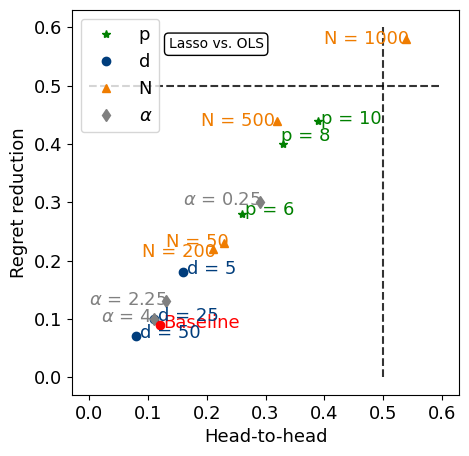

In [46]:
results = pickle.load( open( Result_Path_Section + '414Aginst_lsorgi.pickle', "rb" ) )
p_range = [4 + 2*i for i in range(4)]
d_range = [5, 10, 25, 50]
N_range = [50,100,200,500,1000]
alpha_range = [0.25, 1, 2.25, 4]
Results_p = results[0]
Results_d = results[1]
Results_N = results[2]
Results_alpha = results[3]
mci_p = []
h2h_p = []
mci_d = []
h2h_d = []
mci_N = []
h2h_N = []
mci_alpha = []
h2h_alpha = []
for p in p_range:
    mci_p.append(Results_p[p][0])
    h2h_p.append(Results_p[p][1])
for d in d_range:
    mci_d.append(Results_d[d][0])
    h2h_d.append(Results_d[d][1])
for samples_train in N_range: 
    mci_N.append(Results_N[samples_train][0])
    h2h_N.append(Results_N[samples_train][1])
for alpha in alpha_range:
    mci_alpha.append(Results_alpha[alpha][0])
    h2h_alpha.append(Results_alpha[alpha][1])

fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p, mci_p, color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] + 0.005, mci_p[0] - 0.005, 'Baseline', color='red')
plt.text(h2h_p[1] + 0.005, mci_p[1] - 0.001, 'p = 6', color='green')
plt.text(h2h_p[2] - 0.003, mci_p[2] + 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.005, mci_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], mci_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], mci_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], mci_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.007, mci_d[0] - 0.003, 'd = 5', color='#003D7C')
# plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.007, mci_d[2] - 0.003, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] + 0.007, mci_d[3] - 0.003, 'd = 50', color='#003D7C')


plt.plot(h2h_N[0], mci_N[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[2], mci_N[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[3], mci_N[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[4], mci_N[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N[0] - 0.10, mci_N[0] - 0.006, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N[2] - 0.12, mci_N[2] - 0.014, 'N = 200', color='#EF7C00')
plt.text(h2h_N[3] - 0.13, mci_N[3] - 0.008, 'N = 500', color='#EF7C00')
plt.text(h2h_N[4] - 0.14, mci_N[4] - 0.008, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], mci_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], mci_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], mci_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] - 0.13, mci_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] - 0.13, mci_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] - 0.09, mci_alpha[3] - 0.005, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend()

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_p[0], mci_p[0], color='red', marker = "o", linestyle = 'None')
plt.annotate('Lasso vs. OLS', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

fig.savefig(Result_Path_Section + '414_pattern_pdNalpha_lsools.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_Path_Section + '414_pattern_pdNalpha_lsools.pdf', format='pdf', bbox_inches="tight")

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


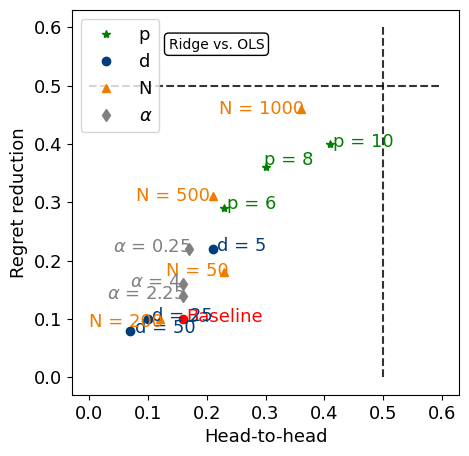

In [47]:
results = pickle.load( open( Result_Path_Section + '414Aginst_lsorgi.pickle', "rb" ) )
Results_p = results[0]
Results_d = results[1]
Results_N = results[2]
Results_alpha = results[3]
mci_p = []
h2h_p = []
mci_d = []
h2h_d = []
mci_N = []
h2h_N = []
mci_alpha = []
h2h_alpha = []
for p in p_range:
    mci_p.append(Results_p[p][2])
    h2h_p.append(Results_p[p][3])
for d in d_range:
    mci_d.append(Results_d[d][2])
    h2h_d.append(Results_d[d][3])
for samples_train in N_range: 
    mci_N.append(Results_N[samples_train][2])
    h2h_N.append(Results_N[samples_train][3])
for alpha in alpha_range:
    mci_alpha.append(Results_alpha[alpha][2])
    h2h_alpha.append(Results_alpha[alpha][3])

fig = plt.figure(figsize = (5, 5))
plt.plot(h2h_p, mci_p, color='green', marker = "*", label = 'p', linestyle = 'None')
plt.text(h2h_p[0] + 0.005, mci_p[0] - 0.005, 'Baseline', color='red')
plt.text(h2h_p[1] + 0.005, mci_p[1] - 0.001, 'p = 6', color='green')
plt.text(h2h_p[2] - 0.003, mci_p[2] + 0.005, 'p = 8', color='green')
plt.text(h2h_p[3] + 0.005, mci_p[3] - 0.005, 'p = 10', color='green')

plt.plot(h2h_d[0], mci_d[0], color='#003D7C', marker = "o", label = 'd', linestyle = 'None')
# plt.plot(h2h_d[1], mci_d[1], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[2], mci_d[2], color='#003D7C', marker = "o", linestyle = 'None')
plt.plot(h2h_d[3], mci_d[3], color='#003D7C', marker = "o", linestyle = 'None')
plt.text(h2h_d[0] + 0.007, mci_d[0] - 0.003, 'd = 5', color='#003D7C')
# plt.text(h2h_d[1] + 0.007, mci_d[1] - 0.003, 'd = 15', color='#003D7C')
plt.text(h2h_d[2] + 0.007, mci_d[2] - 0.003, 'd = 25', color='#003D7C')
plt.text(h2h_d[3] + 0.007, mci_d[3] - 0.003, 'd = 50', color='#003D7C')


plt.plot(h2h_N[0], mci_N[0], color='#EF7C00', marker = "^", label = 'N',linestyle = 'None')
# plt.plot(h2h_N[1], mci_N[1], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[2], mci_N[2], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[3], mci_N[3], color='#EF7C00', marker = "^",linestyle = 'None')
plt.plot(h2h_N[4], mci_N[4], color='#EF7C00', marker = "^",linestyle = 'None')
plt.text(h2h_N[0] - 0.10, mci_N[0] - 0.006, 'N = 50', color='#EF7C00')
# plt.text(h2h_N[1] + 0.005, mci_N[1] - 0.003, 'N = 100', color='#EF7C00')
plt.text(h2h_N[2] - 0.12, mci_N[2] - 0.014, 'N = 200', color='#EF7C00')
plt.text(h2h_N[3] - 0.13, mci_N[3] - 0.008, 'N = 500', color='#EF7C00')
plt.text(h2h_N[4] - 0.14, mci_N[4] - 0.008, 'N = 1000', color='#EF7C00')


plt.plot(h2h_alpha[0], mci_alpha[0], color='grey', marker = "d", label = r'$\alpha$',linestyle = 'None')
# plt.plot(h2h_alpha[1], mci_alpha[1], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[2], mci_alpha[2], color='grey', marker = "d",linestyle = 'None')
plt.plot(h2h_alpha[3], mci_alpha[3], color='grey', marker = "d",linestyle = 'None')
plt.text(h2h_alpha[0] - 0.13, mci_alpha[0] - 0.005, r'$\alpha$ = 0.25', color='grey')
# plt.text(h2h_alpha[1] + 0.005, mci_alpha[1] - 0.005, r'$\alpha$ = 1', color='grey')
plt.text(h2h_alpha[2] - 0.13, mci_alpha[2] - 0.005, r'$\alpha$ = 2.25', color='grey')
plt.text(h2h_alpha[3] - 0.09, mci_alpha[3] - 0.005, r'$\alpha$ = 4', color='grey')

plt.vlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.hlines(0.5, 0.0, 0.6, linestyle="dashed", alpha = 0.8,color = 'k')
plt.legend(loc = 2)

plt.xlabel('Head-to-head')
plt.ylabel('Regret reduction')

plt.plot(h2h_p[0], mci_p[0], color='red', marker = "o", linestyle = 'None')
plt.annotate('Ridge vs. OLS', xy = (0.25,0.9), xycoords = 'axes fraction', bbox=dict(boxstyle="round", fc="w"), size = 10)

fig.savefig(Result_Path_Section + '414_pattern_pdNalpha_rgiols.eps', format='eps', bbox_inches="tight")
fig.savefig(Result_Path_Section + '414_pattern_pdNalpha_rgiols.pdf', format='pdf', bbox_inches="tight")